In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Get started with GANs : digit generator

- generator and discriminator are MLPs (only dense layers)
- per 'digit' generation : a '9' generator for example

In [2]:
# some datasets are available directly with Keras
from keras.datasets.mnist import load_data

Using TensorFlow backend.


x_train : (60000, 28, 28) | uint8
y_train : (60000,) | uint8
x_test : (10000, 28, 28) | uint8
y_test : (10000,) | uint8


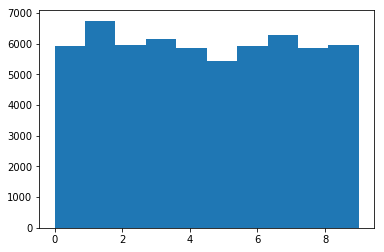

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

print("x_train : {} | {}".format(x_train.shape, x_train.dtype))
print("y_train : {} | {}".format(y_train.shape, y_train.dtype))
print("x_test : {} | {}".format(x_test.shape, x_test.dtype))
print("y_test : {} | {}".format(y_test.shape, y_test.dtype))
_ = plt.hist(y_train, bins=10)

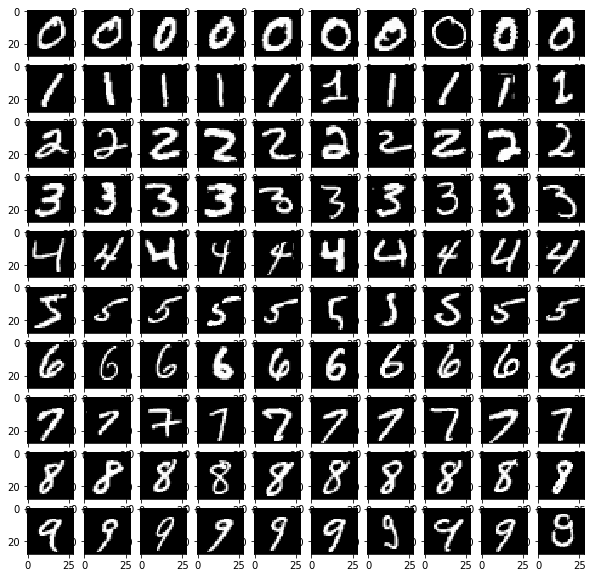

In [4]:
fig = plt.figure(figsize=(10, 10))
for id_class in range(10):
    indices = np.where(y_train==id_class)[0]
    for i in range(10):
        plt.subplot(10, 10, id_class*10 + i + 1)
        plt.imshow(x_train[indices[i]], cmap='gray')
plt.show()

In [5]:
# minimal pre-processsing for GAN : scale to [-1, 1] ---> tanh at the end of the generator
# add new 'dim' : channel dimension 
x_train = (np.expand_dims(x_train, axis=-1).astype(np.float32)/ 127.5) -1
x_test = (np.expand_dims(x_test, axis=-1).astype(np.float32)/ 127.5) - 1

# '9' GAN

In [6]:
from keras.layers import BatchNormalization, Dense, LeakyReLU, InputLayer, Reshape, Flatten, Input
from keras.models import Sequential, Model

from keras.optimizers import Adam

In [7]:
z_dim = 64
img_height = 28
img_width = 28
num_features = 28*28

### Generator

In [8]:
generator = Sequential()
        
generator.add(InputLayer(input_shape=(z_dim,)))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(num_features, activation='tanh'))
generator.add(Reshape((img_height, img_width, 1)))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

In [9]:
# need to compile the generator right now, to have a 'callable' model later
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5))

## Discriminator

In [10]:
discriminator = Sequential()
discriminator.add(InputLayer(input_shape=(img_height, img_width,1)))
discriminator.add(Flatten())
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total para

In [11]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])

## Combine 'G' and 'D', to train 'G'

In [12]:
discriminator.trainable = False

gan_input = Input(shape=(z_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(inputs=gan_input, outputs=gan_output)

In [13]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         578704    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 533505    
Total params: 1,112,209
Trainable params: 576,912
Non-trainable params: 535,297
_________________________________________________________________


In [14]:
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, beta_1=0.5), metrics=["accuracy"])

## Joint training

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
x_train_9 = x_train[np.where(y_train==9)]
print(x_train_9.shape)

(5949, 28, 28, 1)


In [17]:
batch_size = 32
num_steps = 15000

#### Batch generator of 'real' samples 

In [18]:
batch_gen = ImageDataGenerator().flow(batch_size=batch_size,
                                      x=x_train_9,
                                      shuffle=True)

(32, 28, 28, 1) float32


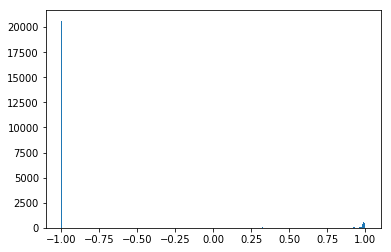

In [19]:
x = batch_gen.next()
print(x.shape, x.dtype)
_ = plt.hist(x.flatten(), bins=255)

-**Note** : 1<->fake | 0<->real  

In [20]:
i = 0

In [21]:
for step in range(num_steps):
    ###################################### TRAIN THE DISCRIMINATOR ###############################
    discriminator.trainable = True
    # generate fake images
    random_z_vectors = np.random.normal(size=(batch_size, z_dim))
    fake_images = generator.predict(random_z_vectors)
    labels = np.ones((batch_size, 1), dtype=np.float32)
    d_loss_1 = discriminator.train_on_batch(fake_images, labels)


    # get real images
    real_images = batch_gen.next()
    labels = np.zeros((real_images.shape[0], 1), dtype=np.float32)
    d_loss_2 = discriminator.train_on_batch(real_images, labels)

    # ############################################################################################

    ###################################### TRAIN THE GENERATOR ###################################
    discriminator.trainable = False
    random_z_vectors = np.random.normal(size=(batch_size, z_dim))
    misleading_labels = np.zeros((batch_size, 1))
    g_loss = gan.train_on_batch(random_z_vectors, misleading_labels)

    ###############################################################################################
    i +=1
    if i % 50 == 0:
        print("At {} iteration : ".format(i))
        print('\tdiscriminator loss: {}'.format((d_loss_1, d_loss_2)))
        print('\tgenerator loss:  {}'.format(g_loss))
    

At 50 iteration : 
	discriminator loss: ([0.078088716, 1.0], [0.0099345325, 1.0])
	generator loss:  [2.8587155, 0.0]
At 100 iteration : 
	discriminator loss: ([0.029973697, 1.0], [0.0011737305, 1.0])
	generator loss:  [3.6680431, 0.0]
At 150 iteration : 
	discriminator loss: ([0.015477996, 1.0], [0.0016736442, 1.0])
	generator loss:  [4.1553583, 0.0]
At 200 iteration : 
	discriminator loss: ([0.014095279, 1.0], [0.0015260883, 1.0])
	generator loss:  [4.4872303, 0.0]
At 250 iteration : 
	discriminator loss: ([0.012161665, 1.0], [0.00092124718, 1.0])
	generator loss:  [4.746182, 0.0]
At 300 iteration : 
	discriminator loss: ([0.010375815, 1.0], [0.0032427965, 1.0])
	generator loss:  [4.9071932, 0.0]
At 350 iteration : 
	discriminator loss: ([0.02182924, 1.0], [0.0050767697, 1.0])
	generator loss:  [5.3251352, 0.0]
At 400 iteration : 
	discriminator loss: ([0.039702188, 1.0], [0.0028086023, 1.0])
	generator loss:  [4.8473196, 0.0]
At 450 iteration : 
	discriminator loss: ([0.081161305, 0.

At 3350 iteration : 
	discriminator loss: ([0.6845789, 0.59375], [0.65908021, 0.625])
	generator loss:  [0.64963484, 0.625]
At 3400 iteration : 
	discriminator loss: ([0.6867395, 0.59375], [0.76061237, 0.46875])
	generator loss:  [0.69854259, 0.4375]
At 3450 iteration : 
	discriminator loss: ([0.76345986, 0.59375], [0.69202316, 0.53125])
	generator loss:  [0.68393588, 0.53125]
At 3500 iteration : 
	discriminator loss: ([0.72829956, 0.34375], [0.69918829, 0.46875])
	generator loss:  [0.67961115, 0.5625]
At 3550 iteration : 
	discriminator loss: ([0.78598464, 0.21875], [0.65282845, 0.625])
	generator loss:  [0.70495987, 0.5]
At 3600 iteration : 
	discriminator loss: ([0.73900151, 0.34375], [0.73224449, 0.5])
	generator loss:  [0.70050812, 0.59375]
At 3650 iteration : 
	discriminator loss: ([0.68007696, 0.78125], [0.67297745, 0.46875])
	generator loss:  [0.68391931, 0.46875]
At 3700 iteration : 
	discriminator loss: ([0.67453563, 0.5625], [0.74691641, 0.40625])
	generator loss:  [0.693712

At 6650 iteration : 
	discriminator loss: ([0.69597858, 0.5625], [0.64923012, 0.59375])
	generator loss:  [0.68437409, 0.5]
At 6700 iteration : 
	discriminator loss: ([0.65692478, 0.5625], [0.55064213, 0.8125])
	generator loss:  [0.71473157, 0.5]
At 6750 iteration : 
	discriminator loss: ([0.65337527, 0.71875], [0.6507206, 0.59375])
	generator loss:  [0.70057917, 0.53125]
At 6800 iteration : 
	discriminator loss: ([0.69169366, 0.59375], [0.66655862, 0.65625])
	generator loss:  [0.68620807, 0.53125]
At 6850 iteration : 
	discriminator loss: ([0.66832852, 0.53125], [0.60327423, 0.75])
	generator loss:  [0.73313999, 0.34375]
At 6900 iteration : 
	discriminator loss: ([0.73461163, 0.34375], [0.65849352, 0.625])
	generator loss:  [0.71438563, 0.4375]
At 6950 iteration : 
	discriminator loss: ([0.6746068, 0.65625], [0.60703599, 0.6875])
	generator loss:  [0.74181825, 0.34375]
At 7000 iteration : 
	discriminator loss: ([0.69217873, 0.5625], [0.66760898, 0.5625])
	generator loss:  [0.72003174,

At 9900 iteration : 
	discriminator loss: ([0.6808064, 0.4375], [0.66163969, 0.65625])
	generator loss:  [0.73287416, 0.34375]
At 9950 iteration : 
	discriminator loss: ([0.72310305, 0.5], [0.6806736, 0.5])
	generator loss:  [0.70919055, 0.375]
At 10000 iteration : 
	discriminator loss: ([0.66402471, 0.65625], [0.6689055, 0.6875])
	generator loss:  [0.72497171, 0.46875]
At 10050 iteration : 
	discriminator loss: ([0.6404736, 0.625], [0.6240387, 0.59375])
	generator loss:  [0.70961523, 0.5]
At 10100 iteration : 
	discriminator loss: ([0.71390027, 0.53125], [0.64891392, 0.5625])
	generator loss:  [0.71842432, 0.40625]
At 10150 iteration : 
	discriminator loss: ([0.67822808, 0.5625], [0.6329717, 0.71875])
	generator loss:  [0.71634936, 0.40625]
At 10200 iteration : 
	discriminator loss: ([0.69244617, 0.59375], [0.64303797, 0.5625])
	generator loss:  [0.72512162, 0.40625]
At 10250 iteration : 
	discriminator loss: ([0.68300188, 0.625], [0.68027115, 0.6875])
	generator loss:  [0.71734959, 0

At 13150 iteration : 
	discriminator loss: ([0.62698787, 0.75], [0.65851104, 0.59375])
	generator loss:  [0.71288568, 0.4375]
At 13200 iteration : 
	discriminator loss: ([0.68207824, 0.53125], [0.69420189, 0.4375])
	generator loss:  [0.71814424, 0.40625]
At 13250 iteration : 
	discriminator loss: ([0.66199011, 0.6875], [0.63645148, 0.6875])
	generator loss:  [0.71775037, 0.46875]
At 13300 iteration : 
	discriminator loss: ([0.65145552, 0.65625], [0.67624295, 0.5625])
	generator loss:  [0.72133285, 0.34375]
At 13350 iteration : 
	discriminator loss: ([0.70380616, 0.625], [0.67944384, 0.5])
	generator loss:  [0.7415446, 0.375]
At 13400 iteration : 
	discriminator loss: ([0.64927119, 0.65625], [0.68869281, 0.46875])
	generator loss:  [0.72720164, 0.5625]
At 13450 iteration : 
	discriminator loss: ([0.69889051, 0.53125], [0.64629191, 0.59375])
	generator loss:  [0.70909047, 0.4375]
At 13500 iteration : 
	discriminator loss: ([0.67474979, 0.5625], [0.66908932, 0.6875])
	generator loss:  [0.

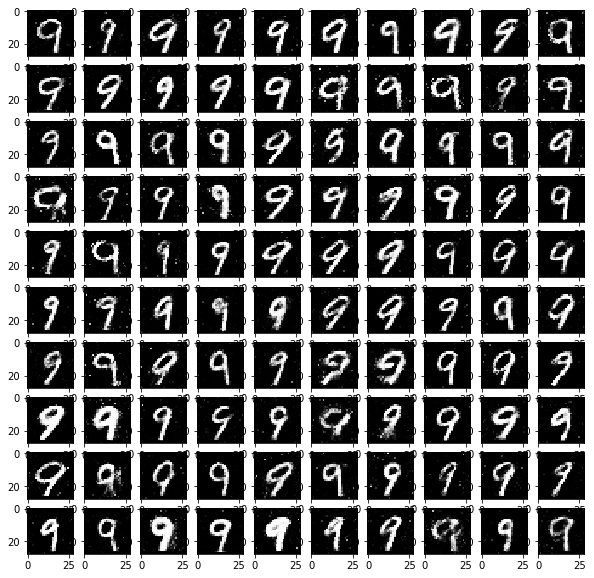

In [22]:
random_z_vectors = np.random.normal(size=(100, z_dim))
fake_images = generator.predict(random_z_vectors)


fig = plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(fake_images[i,:,:,0], cmap='gray')
plt.show()